# 04. PyTorch Custom Datasets Video Notebook

We've used some datasets with PyTorch before

But how do you get your own data into PyTorch?

One way to do this is via custom datasets

**Note**: Depending on what we're looking for (or working on), be it vision, text, audio, recommendation... you'll want to look into each of the PyTorch domain librearies for existing data loading functions and customizable data loading functions.

## 01. Get the data

Our dataset is a subset of the Food101 dataset.

Food101 starts with 101 different classes of food (750 training, 250 testing)

Our dataset starts with 3 clases and only 10% of the images (~75 training, 25 testing)

Why do this?

When starting out ML projects, it's important to try things on a small scale and then increase the scale when necessary.

The whole point is to speed up how fast you ca experiment

In [4]:
import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder does not exist, download and prepare it

if image_path.is_dir():
    print(f"{image_path} directory already exists... skipping download.")
else:
    print(f"{image_path} directory does not exists... creating it.")
    image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak and sushi dataset
with open(image_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza, sushi and steak dataset")
    f.write(request.content)

# Unzip pizza, sushi and steak data
with zipfile.ZipFile(image_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak and sushi data...")
    zip_ref.extractall(image_path)

data/pizza_steak_sushi directory does not exists... creating it.
Unzipping pizza, steak and sushi data...


## 2. Becoming one with the data (data exploration and data preparation)


In [5]:
import os

def walk_through_dir(dir_path):
    """Walks through dir_path returning its content"""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [6]:
walk_through_dir(image_path)

There are 2 directories and 1 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.


In [7]:
# Set up training and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing an image

Let's write some code to:
1. Get all of the images from a path
2. Pick a random image using Python's `random.choice()`
3. Get the class image using `pathlib.Path.parent.stem`
4. Since we're working with images, let's open the image with PIL
5. We'll get the metadata to show it along the image

Random image path: data/pizza_steak_sushi/test/steak/1302563.jpg
Image class: steak
Image height: 512
Image width: 512


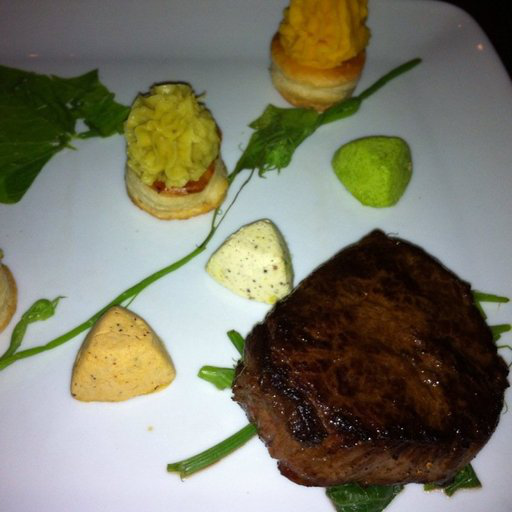

In [9]:
import random
from PIL import Image

# Set seed
random.seed(42) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img


We can do the same with `matplotlib.pyplot.imshow()`, except we have to convert the image to a NumPy array first.

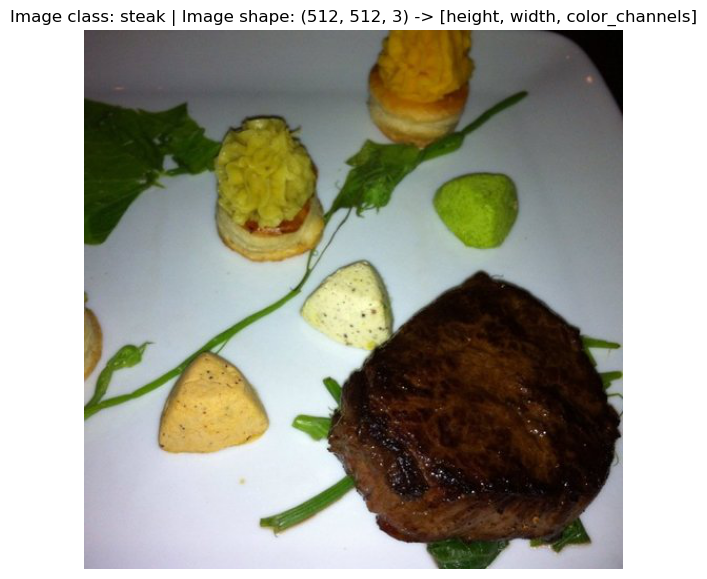

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

In [11]:
img_as_array

array([[[ 76,  66,  67],
        [ 77,  66,  70],
        [ 78,  67,  71],
        ...,
        [  2,   2,   0],
        [  3,   3,   1],
        [  3,   3,   1]],

       [[ 76,  66,  67],
        [ 77,  66,  70],
        [ 78,  67,  71],
        ...,
        [  2,   2,   0],
        [  3,   3,   1],
        [  3,   3,   1]],

       [[ 75,  65,  66],
        [ 77,  66,  70],
        [ 79,  68,  72],
        ...,
        [  2,   2,   0],
        [  3,   3,   1],
        [  3,   3,   1]],

       ...,

       [[164, 160, 177],
        [164, 159, 179],
        [165, 160, 180],
        ...,
        [144, 142, 155],
        [142, 140, 153],
        [141, 139, 152]],

       [[164, 160, 177],
        [165, 160, 180],
        [165, 160, 180],
        ...,
        [145, 143, 156],
        [144, 142, 155],
        [144, 142, 155]],

       [[166, 162, 179],
        [166, 161, 181],
        [167, 162, 182],
        ...,
        [146, 144, 158],
        [147, 145, 159],
        [148, 146, 160]]

## 3. Transforming data

Before we can use our image data with PyTorch:

1. Turn the target data into tensors (in our case, numerical representation of our images).
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, we'll call these `Dataset` and `DataLoader` for short.

In [12]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`

In [21]:
data_transform = transforms.Compose([
    # Resize our images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal axis
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a torch Tensor
    transforms.ToTensor()
])

In [22]:
data_transform(img)

tensor([[[0.0078, 0.0118, 0.0118,  ..., 0.3176, 0.3098, 0.3098],
         [0.0118, 0.0118, 0.0196,  ..., 0.3216, 0.3137, 0.3137],
         [0.0118, 0.0118, 0.0196,  ..., 0.3294, 0.3255, 0.3098],
         ...,
         [0.6353, 0.6549, 0.6824,  ..., 0.7216, 0.7020, 0.6902],
         [0.6118, 0.6353, 0.6667,  ..., 0.7059, 0.6902, 0.6706],
         [0.5882, 0.6196, 0.6431,  ..., 0.6980, 0.6784, 0.6627]],

        [[0.0078, 0.0078, 0.0078,  ..., 0.2941, 0.2824, 0.2745],
         [0.0078, 0.0078, 0.0039,  ..., 0.2980, 0.2863, 0.2745],
         [0.0078, 0.0078, 0.0078,  ..., 0.3020, 0.2902, 0.2824],
         ...,
         [0.6275, 0.6510, 0.6745,  ..., 0.7020, 0.6824, 0.6627],
         [0.6039, 0.6314, 0.6627,  ..., 0.6863, 0.6706, 0.6510],
         [0.5843, 0.6196, 0.6471,  ..., 0.6784, 0.6588, 0.6431]],

        [[0.0000, 0.0039, 0.0039,  ..., 0.2941, 0.2941, 0.2941],
         [0.0039, 0.0000, 0.0000,  ..., 0.3059, 0.3020, 0.2941],
         [0.0039, 0.0000, 0.0000,  ..., 0.3176, 0.3098, 0.

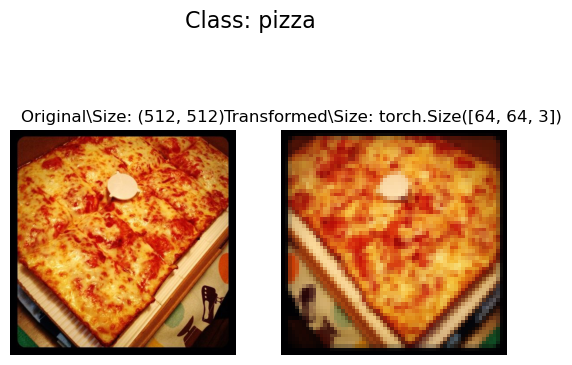

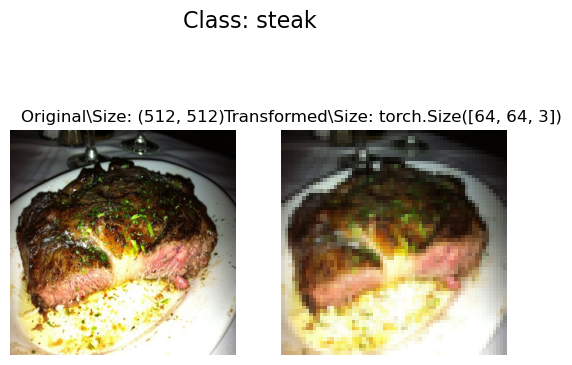

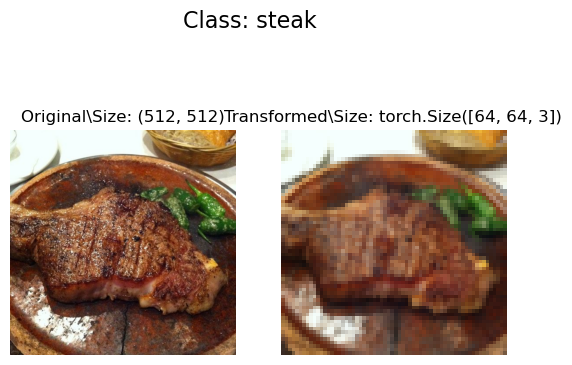

In [70]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """
    Selects random images and loads/transforms them. Then plots the original vs the transformed version.
    """

    if seed:
        random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original\Size: {f.size}")
            ax[0].axis(False)

            # transform and plot target image
            transformed_image = transform(f).permute(1,2,0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed\Size: {transformed_image.shape}")
            ax[1].axis(False)

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=44)

### 4. Option 1:loading image data using `ImageFolder`

We can load an image classification data using `torchvision.datasets.ImageFolder`

In [24]:
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None) # A transform target/label

test_data = datasets.ImageFolder(root=test_dir,
                                  transform=data_transform,
                                  target_transform=None) # A transform target/label

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [26]:
# get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [27]:
# Get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [28]:
# Check the length of our dataset
len(train_data), len(test_data)

(225, 75)

In [31]:
# Index on the train_data Dataset to get a simgle label and image
img, label = train_data[0][0], train_data[0][1]

In [32]:
img

tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0863],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0706],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0196,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.0902, 0.0902, 0.

In [34]:
class_names[label]

'pizza'

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


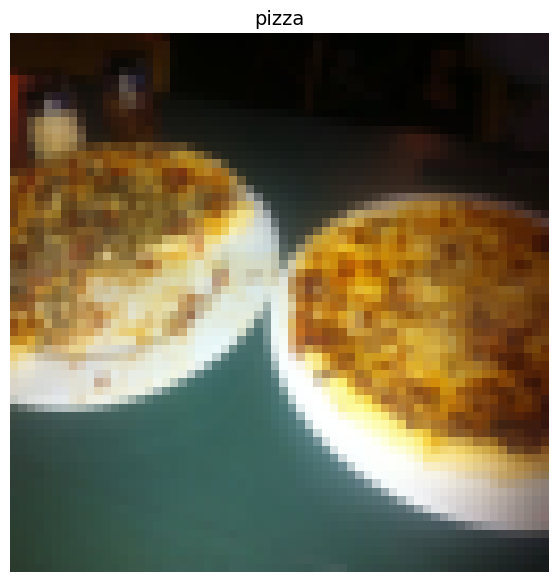

In [35]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

## 4.1 Turn loaded images to `Dataloader`'s

A `DataLoader` is going to help us turn our `Dataset`'s' into iterables and we can customise the `batch_size` so our model can see `batch_size` images at a time.

In [38]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=4,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              num_workers=4,
                              shuffle=True)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f8b24494d60>,
 <torch.utils.data.dataloader.DataLoader at 0x7f8b24494c40>)

In [39]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([32, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


## Option 2: Loading Image Data with a Custom `Dataset`

1. Want to be able to lead images from file
2. Want to be able to get a class from the `Dataset`
3. Want to be able to get classes as dictionary from the `Dataset`

Pros:
* Can create `Dataset` out of almost anything
* Not limited to PyTorch pre-built `Dataset` functions 

Cons:
* Even though you could create a `Dataset` out of almost anything, ut doesn't mean it will work... but it will
* Using a custom `Dataset` often results in us writing more code, which could be more prone to more errors


In [40]:
import os
import pathlib 
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [41]:
# We want to replicate this functionality that torch.utils.data.ImagaeFolder() has
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Create a helper function to get class names

We want a function to:
1. Get the class names using `os.scandir()` to traverse a target directory (in standard image classification format).
2. Raise an error if teh class names aren't found (if this happens, there might be something wrong in our dataset)
3. Turn the class names into a dict and a list an return them

In [42]:
# Set up path for target directory
target_directory = train_dir
print(f"Target dir: {target_directory}")

# get the class names froom the target directory
class_names_found = sorted(entry.name for entry in list(os.scandir(target_directory)))
class_names_found

Target dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [44]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """
    Finds the class folder names in a target directory.
    """

    # 1. Get the class names by scaning the target directory
    classes = sorted(entry.name for entry in list(os.scandir(directory)) if entry.is_dir())

    # 2. Raise an error if class names could not be found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}... please check file structure.")
    
    # 3. Create a dictionary of index labels 
    class_to_idx = {class_name:i for i, class_name in enumerate(classes)}
    return classes, class_to_idx

In [45]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

To create our own custom datset, we want to:

1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with a target directory (the directory we'd like to get data from) as well as transform if we'd like to transform our data.
3. Create several attributes:
    * paths - paths of our images
    * transform - the transform we'd like to use
    * classes - a list of the target classes
    * class_to-idx - a dict o fthe target classes mapped to integer labels
4. Create a function to `load_images()`, this functions will open a image
5. Overwrite the `__len__()`mathod to return the length of our dataset
6. Oberwrite the `__getitem()__` mathod to return a given sample when passed in index

In [46]:
# Write a custom dataset class
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
    # 2. Initialize our custom dataset
    def __init__(self, targ_dir: str, transform=None) -> None:
        super().__init__()
        # 3. Create a class attributes 
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
        # setup transforms
        self.transform = transform
        # Create classes and class_to_idx attributes
        self.classes, self.class_to_idx = find_classes(targ_dir)

    # Create a function to load images
    def load_image(self, index: int):
        "Opens a image via a path and returns it."
        image_path = self.paths[index]
        return Image.open(image_path)
    
    # 5. Overwrite __len__()
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.paths)
    
    # 6. Overwrite __getitem__() method to return a particular sample
    def __getitem__(self, index:int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X, y)."
        img = self.load_image(index=index)
        class_name = self.paths[index].parent.name # expects path in format: data_folder/class_name/image.jpg
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx # return data, label (X, y)
        else:
            return img, class_idx

In [47]:
# Create a transform
from torchvision import transforms
train_transform_compose = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transform_compose = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [49]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transform_compose)


test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                      transform=train_transform_compose)

In [53]:
len(train_data), len(train_data_custom)

(225, 225)

In [56]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [55]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [58]:
# Check for equiality between original ImageFolder Dataset and ImageFolderCustomDataset
print(train_data_custom.classes == train_data.classes)
print(test_data_custom.classes == test_data.classes)

True
True


### 5.3 Create a function to display random images


1. Take in a `Dataset` and a number of other parameters, such as class names and how many images to visualize.
2. To prevent the display getting out of hand, let's cap the number of images to see at 10.
3. Set random seed to reproducibility
4. Get a list of random indexes from the target dataset
5. Set up a matplotlib plot
6. Loop through the random sample images and plot them with matplotlib.
7. Make sure the dimensiones of pour images line up with matplotlib (HWC)

In [60]:
# 1. Create function to take in a dataset

def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n : int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    # 2. Adjuts display if n is too long
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be higher than 10, setting to 10 the number of samples")
    
    # 3. Set the seed
    if seed: 
        random.seed(seed)

    # 4. Get random sample indexes
    random_sample_idx = random.sample(range(len(dataset)), k=n)

    # 5.Set up a matplotlib plot
    plt.figure(figsize=(16,8))

    # 6. Loop through the random sample images and plot them with matplotlib.
    for i, targ_sample in enumerate(random_sample_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # Adjust tensor dimensions for plotting
        targ_image_adjust = targ_image.permute(1, 2, 0) # from C, H, W to H, W, C

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis(False)
        if classes:
            title = f"Class: {classes[targ_label]}"
            if display_shape:
                title += f"\n Shape {targ_image_adjust.shape}"

        plt.title(title)

    

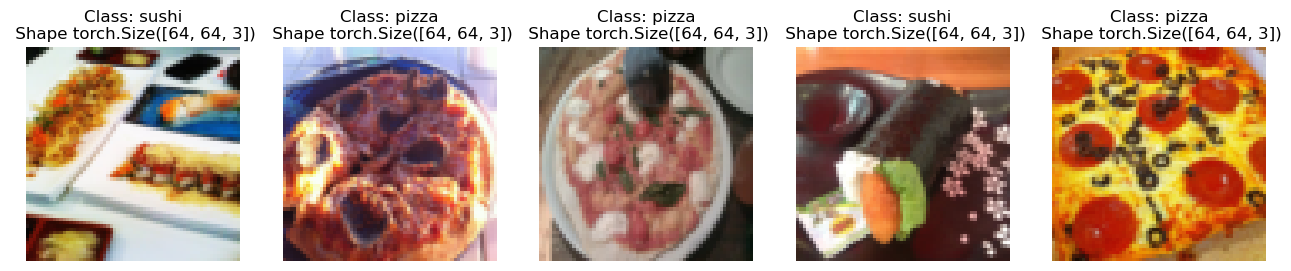

In [61]:
display_random_images(train_data,
                      n=5,
                      classes=class_names,
                      seed=42)

For display purposes, n shouldn't be higher than 10, setting to 10 the number of samples


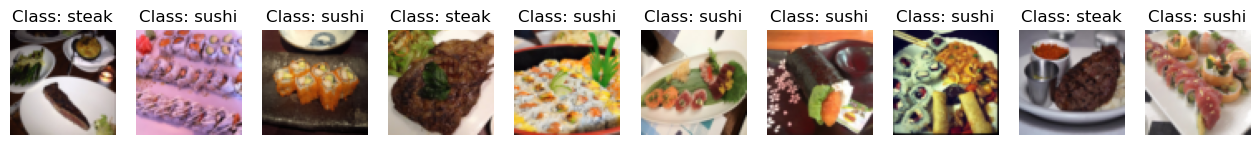

In [63]:
# Display random images from the ImageFolderCustom Dataset
display_random_images(train_data_custom,
                      n=11,
                      classes=class_names,
                      seed=42)

### 5.4 Turn custom loaded images into `DataLoader`'s

In [66]:
# Turn train and test custom Dataset's into DataLoader's
from torch.utils.data import DataLoader

BATCH_SIZE = 32
train_dataloader_custom = DataLoader(dataset=train_data_custom, # use custom created train Dataset
                                     batch_size=BATCH_SIZE, # how many samples per batch?
                                     num_workers=0, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True) # shuffle the data?

test_dataloader_custom = DataLoader(dataset=test_data_custom, # use custom created test Dataset
                                    batch_size=BATCH_SIZE, 
                                    num_workers=0, 
                                    shuffle=False) # don't usually need to shuffle testing data

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7f8b24345de0>,
 <torch.utils.data.dataloader.DataLoader at 0x7f8b243444c0>)

In [67]:
# Get image and label from custom DataLoader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")

Image shape: torch.Size([32, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


### 6. Other form of transforms (data augmentation)

Data augmentation is the process of artificially, adding diversity to your training data. 

In the case of image data, this may mean applying various image transformation to training inages.

This practice hopefully results in a model that's model generalizable to unseen data.

Let's take a look at one aprticular type of data augmentation used tot train PyTorch vision models to state of the art levels...

In [68]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # how intense 
    transforms.ToTensor() # use ToTensor() last to get everything between 0 & 1
])

# Don't need to perform augmentation on the test data
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor()
])

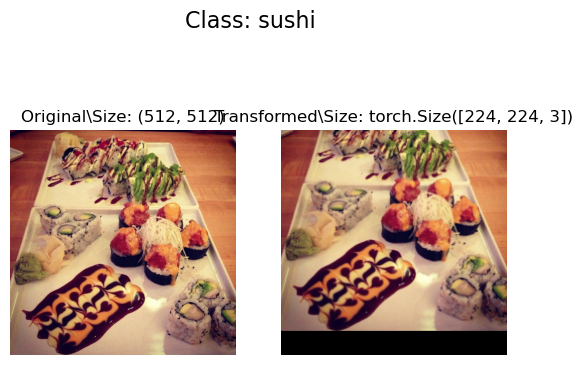

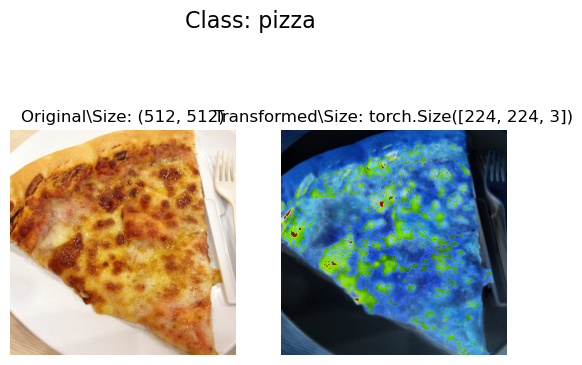

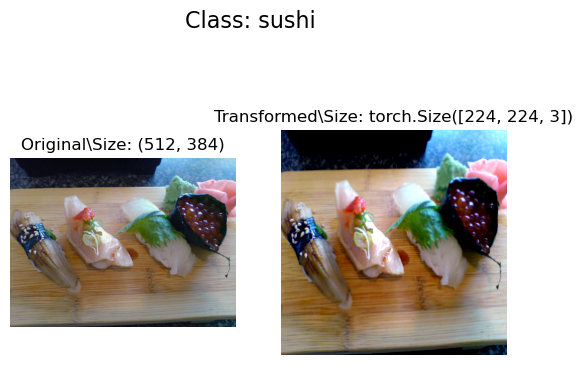

In [72]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# Plot random images
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transforms,
    n=3,
    seed=None
)

## 7. Model 0: TinyVGG without data augmentatiom

Let's replicate TinyVGG architecture from the CNN Explainer website.

### 7.1 Creating transforms and loading data for Model 0

In [73]:
# Create simple transform
simple_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [74]:
# 1. Load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform)

test_data_simple = datasets.ImageFolder(root=test_dir,
                                         transform=simple_transform)

# 2. Turn the datasets into DataLoaders
import os 
from torch.utils.data import DataLoader

# Set up batch size and number of workers
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# create DataLoaders
train_dataloader_sime = DataLoader(dataset=train_data_simple,
                                   batch_size=BATCH_SIZE,
                                   shuffle=True,
                                   num_workers=NUM_WORKERS)

test_dataloader_sime = DataLoader(dataset=test_data_simple,
                                   batch_size=BATCH_SIZE,
                                   shuffle=True,
                                   num_workers=NUM_WORKERS)

### 7.2 Create TinyVGG model class

In [76]:
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"

class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_data.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)